In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.animation import FuncAnimation
import matplotlib
import scipy.sparse as sps
from tqdm import tqdm
# matplotlib.rcParams['figure.figsize'] = [8, 7]

## Initializing the Mesh

In [16]:
domain_length = 1
meshsize = 1000

dx = domain_length/meshsize*np.ones((meshsize))

x = np.ones((meshsize))
x[0] = dx[0]/2
for i in range(1,meshsize):
    x[i] = x[i-1] + dx[i-1]/2+dx[i]/2

## Entering phase diagram properties

In [17]:
c0 = 2.1

ceut = 4.2
calpha = 2.1

Tf = 1537
Teut = 1153

Tliq = (Teut-Tf)/ceut*c0 + Tf
Tsol = (Teut-Tf)/calpha*c0+Tf

kpar = calpha/ceut
T_init_cast = Tliq

c = c0*np.ones((meshsize))
cinit = c.copy()

def cl(T, Tf=Tf, ceut=ceut, Teut=Teut):
    return (T-Tf)*ceut/(Teut-Tf)

In [18]:
total_t = 100000
dt = 10

t = np.arange(0,total_t,dt)

T = np.linspace(Tliq, Tsol, int(total_t/dt))

In [19]:
def simulateLever(x,c,t=t,T=T,k=kpar):
    
    inter = 0

    profiles = [(c.copy(),0)]
    for i in range(1,len(t)):

        #Finding out the solid part

        isSolid = np.zeros((len(x)))
        isLiquid = np.zeros((len(x)))
        isSolid[0:int(inter)] = 1

        # Finding the change in interface
        jump = 3
        d_inter = jump
        change = 10

        while abs(change)>0.01:

            isLiquid[int(inter+d_inter)+1:] = 1
            
            solid_change = np.sum(np.dot(isSolid,k*cl(T[i]))) - np.sum(np.dot(isSolid,c))
            liquid_change = np.sum(np.dot(isLiquid,cl(T[i]))) - np.sum(np.dot(isLiquid,c))
            
            #Figuring out the change in the two interface nodes
            node1_change = (inter%1)*(k*cl(T[i]) - k*cl(T[i-1]))
            node2_change = (1 - (inter+d_inter)%1)*(cl(T[i])-c[int(inter+d_inter)])
            #Total mass change apart from interface movement
            inter_change = -(solid_change+liquid_change+node1_change+node2_change)
            #####
            print(inter_change)
            #Figuring out the jump again
            initial_conc = (1-(inter)%1)*cl(T[i-1]) + np.sum(c[int(inter):int(inter+d_inter)]) + ((inter+d_inter)%1)*c[int(inter + d_inter)]
            ######
            print(initial_conc)
            d_inter_new = (inter_change+initial_conc)/(k*cl(T[i]))
            ######
            print(d_inter_new)
            change = d_inter_new-d_inter
            ######
            print(change)
            d_inter = d_inter_new
            print(inter+d_inter)
            print()
        
        # Diffusion in solid and liquid
        if(int(inter)!=int(inter+d_inter)):
            c[int(inter)+1:int(inter+d_inter)] = k*cl(T[i])
        #Diffusion in solid
        c[0:int(inter)] = k*cl(T[i])
        #Diffusion in liquid
        c[int(inter+d_inter)+1:] = cl(T[i])
        #Node 1
        c[int(inter)] = k*cl(T[i])
        #Node 2
        c[int(inter+d_inter)] = ((inter+d_inter) %1)*k*cl(T[i]) + (1 - ((inter+d_inter) % 1))*cl(T[i])

        inter = inter + d_inter
        
        profiles.append((c.copy(),inter))

        if inter+jump>len(x):
            print("Simulation finish")
            break
    return profiles


In [20]:
def simulateScheil(x, c, t=t, T=T, k=kpar):

    c0 = np.average(c)
    inter = 0
    profiles = [(c.copy(), 0,0)]
    for i in range(0, len(t)):
        #Finding out the temperature
        temp = T[i]

        #Finding out the solid part
        isSolid = np.zeros((len(x)))
        isLiquid = np.zeros((len(x)))
        isSolid[0:inter] = 1

        # Finding the change in interface
        jump = 3

        d_inter = jump
        change = 10

        while abs(change) > 1:

            isLiquid[inter+d_inter:] = 1

            # Mass Change
            solid_change = 0
            liquid_change = np.sum(np.dot(isLiquid, cl(temp))) - np.sum(np.dot(isLiquid, c))
            # Mass Balance
            inter_change = -(solid_change+liquid_change)
            d_inter_new = inter_change/((k-1)*cl(temp))
            change = d_inter_new-d_inter
            
            # Conservation of mass violated
            d_inter = round(d_inter_new)

        ## Updating the values using new interface

        # Diffusion in solid and liquid
        if d_inter:
            #Interface
            c[inter:inter+d_inter] = k*cl(temp)
            #Solid diffusion

            #Liquid Diffusion
            c[inter+d_inter:] = cl(temp)

        inter = inter + d_inter
        mass_change = np.average(c)-c0
        profiles.append((c.copy(), inter,mass_change))

        if inter+jump > len(x):
            print("Simulation finish")
            break
    return profiles


In [21]:
Scheil = simulateScheil(x.copy(),c.copy())
tf_scheil = (len(Scheil)-1)*dt

In [22]:
Lever = simulateLever(x.copy(), c.copy())
tf_lever = (len(Lever)-1)*dt

-0.20939093909727147
8.4
7.799799999996798
4.799799999996798
7.799799999996798

-0.20922296429979248
18.479579999993277
17.3985999999904
9.5987999999936
17.3985999999904

-0.20930722472583638
38.63705999997984
36.594199999977604
19.195599999987206
36.594199999977604

-0.20926614461782828
78.94781999995294
74.98159999995198
38.38739999997438
74.98159999995198

-0.2091847824816201
159.56135999989917
151.74879999990077
76.76719999994879
151.74879999990077

-0.20923367537091975
320.77247999979164
305.2677999997984
153.51899999989763
305.2677999997984

-0.2093346954729514
643.1623799995767
612.2749999995937
307.00719999979526
612.2749999995937

-0.20933318332177928
1287.877499999147
1226.2279999991842
613.9529999995906
1226.2279999991842



IndexError: index 1226 is out of bounds for axis 0 with size 1000

In [ ]:
interface_Lever = np.zeros(len(Lever))
for i in range(0, len(Lever)):
    interface_Lever[i] = Lever[i][1]

In [ ]:
interface_Scheil = np.zeros(len(Scheil))
for i in range(0,len(Scheil)):
    interface_Scheil[i] = Scheil[i][1]

In [ ]:
mass_change = np.zeros(len(Scheil))
for i in range(0, len(Scheil)):
    mass_change[i] = Scheil[i][2]

In [ ]:
plt.plot(Lever[-1][0])
print(tf_lever)

100000


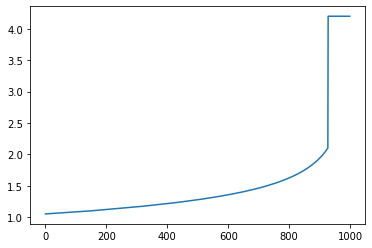

In [ ]:
plt.plot(Scheil[-1][0])
print(tf_scheil)

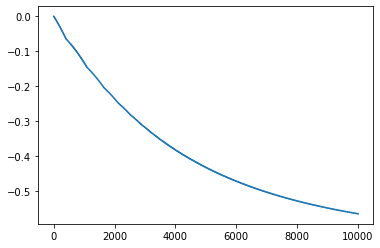

In [ ]:
plt.plot(mass_change)